In [1]:
import tushare as ts
import pandas as pd 
from datetime import datetime
import baostock as bs
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

##tushare上直接调取沪深300的成分和权重需要2000积分，因此我直接去中证指数网站上找了一个，另存为csv文件进行处理

In [2]:
#读取沪深300的股票列表
hs_300_names = pd.read_csv('000300cons.csv',dtype={'成分券代码Constituent Code':str})
#添加一列'tscode'来使得tushare可以理解股票代码
hs_300_names['ts_code'] = pd.Series(dtype='float64')
hs_300_names['ts_code'] = hs_300_names.apply(lambda x: (x['成分券代码Constituent Code']+'.SZ') if (x['交易所Exchange']=='深圳证券交易所') else x['ts_code'],axis=1)
hs_300_names['ts_code'] = hs_300_names.apply(lambda x: (x['成分券代码Constituent Code']+'.SH') if (x['交易所Exchange']=='上海证券交易所') else x['ts_code'],axis=1)
#添加一列'bs_code'来使得baostock可以理解数据
hs_300_names['bs_code'] = pd.Series(dtype='float64')
hs_300_names['bs_code'] = hs_300_names.apply(lambda x: ('sz.'+x['成分券代码Constituent Code']) if (x['交易所Exchange']=='深圳证券交易所') else x['ts_code'],axis=1)
hs_300_names['bs_code'] = hs_300_names.apply(lambda x: ('sh.'+x['成分券代码Constituent Code']) if (x['交易所Exchange']=='上海证券交易所') else x['ts_code'],axis=1)

In [3]:
#获取过去一个月内的行情数据
pro = ts.pro_api('ef72c5f61ef5a1bc11f45f72ad053a92ed4fb60e3d06a8474fad40e8')
data = pd.DataFrame()
for tscode in hs_300_names['ts_code']:
    data = data.append(pro.daily(ts_code = tscode, start_date = '20230225',end_date = '20230325'))
#

##由于同样的理由，我选择去baostock网站上获取市值和eps数据

In [4]:
# 使用baostock系统来获取eps数据和总股数
lg = bs.login()
# 获取最近的eps
profit_list = []
for stock in hs_300_names['bs_code']:
    rs_profit = bs.query_profit_data(code=stock, year=2022, quarter=3)
    profit_list.append(rs_profit.get_row_data())
result_profit = pd.DataFrame(profit_list, columns=rs_profit.fields)

bs.logout()

login success!
logout success!


In [5]:
#这里为了计算eps和总市值
line = data.groupby('ts_code')['close'].mean().reset_index(drop=True)
hs_300_info = pd.DataFrame()
hs_300_info['ave_close'] = line#因为不能直接调出市值，所以采用了收盘价均值乘以股票数量
hs_300_info['eps'] = result_profit['epsTTM'].astype(float)
hs_300_info['ts_code'] = hs_300_names['ts_code']
hs_300_info['totalShare'] = result_profit['totalShare'].astype(float)

##这里发现'sz.002555'缺少数据，可能是baostock网站缺少数据导致的。翻阅22年三季度财报补上。

In [6]:
hs_300_info.loc[106,'eps'] = 1.017523
hs_300_info.loc[106,'totalShare'] = 2217864281.00

In [7]:
#计算市值
hs_300_info['m_value'] = hs_300_info.apply(lambda x:x['ave_close']*x['totalShare'],axis=1)

##研究应该要我使用分层抽样法，以下可能有两种不同的分析情况：先切'eps'还是先切'm_value'(市值)的情况

In [8]:
#先切eps的情况：
useless_a = np.array_split(hs_300_info.sort_values(by='eps'),5)#useless_a列表是一个将hs_300_info首次排序后切成五份的中间变量
hs_300_info_sorted_1 = []
for i in useless_a:
    hs_300_info_sorted_1.append(np.array_split(i.sort_values(by='m_value'),5))#这一步是为了将上面切了五刀后的list中的每一个都再切五刀然后丢尽一个新的list中

result_1 = []
for i in range(5):#双循环以遍历这个切过两次的列表
    s = []
    for j in range(5):
        stocks_now = hs_300_info_sorted_1[i][j]['ts_code']#指定对应的切片中的股票代码
        selected_stocks = data[data['ts_code'].isin(stocks_now)]#data中找出切片对应的代码
        mean = selected_stocks.groupby('trade_date')['pct_chg'].mean()
        s.append({'eps':i,'m_value':j,'stocks_list':hs_300_info_sorted_1[i][j]['ts_code'],'mean':mean})
    result_1.append(s)



In [9]:
#先切市值的情况：
useless_a = np.array_split(hs_300_info.sort_values(by='m_value'),5)#useless_a列表是一个将hs_300_info首次排序后切成五份的中间变量
hs_300_info_sorted_2 = []
for i in useless_a:
    hs_300_info_sorted_2.append(np.array_split(i.sort_values(by='eps'),5))#这一步是为了将上面切了五刀后的list中的每一个都再切五刀然后丢尽一个新的list中

result_2 = []
for i in range(5):#双循环以遍历这个切过两次的列表
    s = []
    for j in range(5):
        stocks_now = hs_300_info_sorted_2[i][j]['ts_code']#指定对应的切片中的股票代码
        selected_stocks = data[data['ts_code'].isin(stocks_now)]#data中找出切片对应的代码
        mean = selected_stocks.groupby('trade_date')['pct_chg'].mean()
        s.append({'m_value':i,'eps':j,'stocks_list':hs_300_info_sorted_2[i][j]['ts_code'],'mean':mean})
    result_2.append(s)


##在以上两大段代码之后，我们已经使用了两种不同的方式对这300股票进行切割，分别是按照'eps'优先还是按照'm_value'优先切割。总共有2组*25个组合，并计算了它们的平均每日收益率。接下来是对这些组合做分析的时候了

In [10]:
#计算累计收益率
cumulative_1 = np.zeros([5,5])#每行代表先切的，每一列代表后切的
cumulative_2 = np.zeros([5,5])
for i in range(5):
    for j in range(5):
        cumulative_1[i][j] = ((result_1[i][j]['mean']/100+1).cumprod()-1)['20230324']
        cumulative_2[i][j] = ((result_2[i][j]['mean']/100+1).cumprod()-1)['20230324']

##上面那一段完成了对不同划分的累计收益计算。接下来是可视化环节

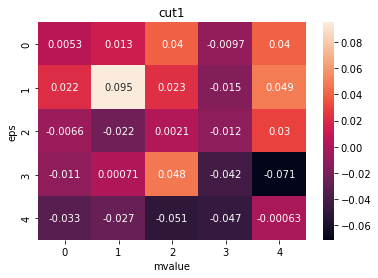

In [11]:
# 绘制热力图
ax = sns.heatmap(cumulative_1,annot=True)
ax.set_xlabel('mvalue')
ax.set_ylabel('eps')
plt.title('cut1')
plt.show()

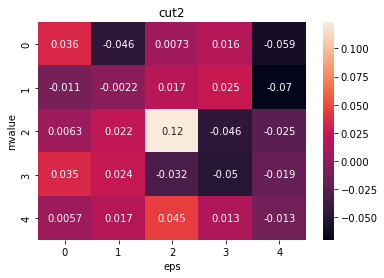

In [12]:
# 绘制热力图
ax = sns.heatmap(cumulative_2,annot=True)
ax.set_xlabel('eps')
ax.set_ylabel('mvalue')
plt.title('cut2')
plt.show()